In [2]:
import deepchem as dc
from deepchem.models import DMPNNModel

In [3]:
import pandas as pd
import numpy as np
import matplotlib as plt
import rdkit
import os
import sys

In [4]:
pip install pubchempy

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pubchempy as pcp
import torch
import torch.nn as nn

from torch_geometric.data import Data, Batch
from deepchem.models.torch_models import layers
from deepchem.feat import GraphData
import deepchem.models.torch_models.layers as torch_layers
from deepchem.models.torch_models.dmpnn import _MapperDMPNN
from deepchem.models.torch_models import DMPNN
from deepchem.models.torch_models import DMPNNModel

from typing import Union, List, Sequence, Optional

In [6]:
# Load delaney dataset
#delaney_tasks, delaney_datasets, transformers = dc.molnet.load_delaney(featurizer=dc.feat.DMPNNFeaturizer(features_generators=["rdkit_desc_normalized"]), splitter='scaffold')

In [6]:
target_df = pd.read_csv('virdis_solu_final_5.csv')
smiles = target_df['smiles'].values
smiles = smiles.astype(str)

In [7]:
#delaney_tasks
featurizer = dc.feat.DMPNNFeaturizer(features_generators=["rdkit_desc_normalized"])
X = featurizer.featurize(smiles)
print(len(X))

2674


In [8]:
target_values = target_df['log_sol'].values
target_values = target_values.astype('float64')
print(len(target_values)) #y

2674


In [9]:
task_1 = ['log_sol']
print(len(task_1))

1


In [10]:
dataset=dc.data.DiskDataset.from_numpy(X=X, y=target_values, ids=smiles, tasks=['log_sol'])
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid = 0.1, seed=0)
transformers = [dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]
print(len(transformers))
for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
            dataset = transformer.transform(dataset)
# transformers_1 = [dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]
# transformers_2 = [dc.trans.NormalizationTransformer(transform_y=True, dataset=valid_dataset)]
# transformers_3 = [dc.trans.NormalizationTransformer(transform_y=True, dataset=test_dataset)]
print('dataset is featurized')

1
dataset is featurized


In [11]:
#train_dataset, valid_dataset, test_dataset = delaney_datasets

In [12]:
# Assess featurized data
print(len(train_dataset), len(valid_dataset), len(test_dataset))
print(train_dataset.X[:5])

2139 267 268
[GraphData(node_features=[8, 133], edge_index=[2, 16], edge_features=[16, 14], global_features=[200])
 GraphData(node_features=[16, 133], edge_index=[2, 32], edge_features=[32, 14], global_features=[200])
 GraphData(node_features=[4, 133], edge_index=[2, 6], edge_features=[6, 14], global_features=[200])
 GraphData(node_features=[18, 133], edge_index=[2, 42], edge_features=[42, 14], global_features=[200])
 GraphData(node_features=[8, 133], edge_index=[2, 16], edge_features=[16, 14], global_features=[200])]


In [13]:
# Initialise the model
model = DMPNNModel(n_tasks = len(task_1), \
                   n_classes = len(train_dataset.X), \
                   mode='regression', \
                   batch_size=50, \
                   global_features_size=200)

In [14]:
# Model training
print("Training model...")
model.fit(train_dataset, nb_epoch=10)

Training model...


0.5248867034912109

In [15]:
# Model evaluation
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)

In [16]:
prediction = model.predict(test_dataset)
print(len(test_dataset.y))
print(len(prediction))
print(len(prediction[1]))


268
268
1


Text(0.5, 1.0, 'DMPNN')

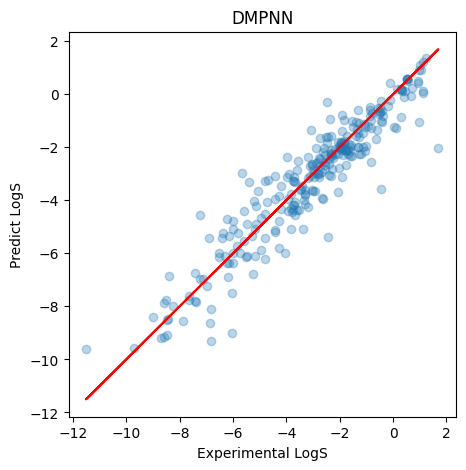

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5,5))
plt.scatter(x=test_dataset.y, y=prediction, alpha=0.3)
plt.plot((test_dataset.y), (test_dataset.y), color = 'red')
plt.ylabel('Predict LogS')
plt.xlabel('Experimental LogS')
plt.title("DMPNN")

In [18]:
# print("Evaluating model->")
# train_scores = model.evaluate(train_dataset, [metric], transformers)
# valid_scores = model.evaluate(valid_dataset, [metric], transformers)
# test_scores = model.evaluate(test_dataset, [metric], transformers)